In [10]:
%%capture
! pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
! pip install numpy
! pip install matplotlib

In [11]:
import gzip
import requests
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path

In [12]:
# Load in MNIST data
folder = Path('data')

urls= [
        'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz' 
        ]

folder.mkdir(exist_ok=True)
for url in urls:
    r = requests.get(url)
    
    if (r.status_code == 200):
        open(Path(folder) / Path(str(url)).name, 'wb').write(r.content)
    else:
        print(r.status_code)
    

In [13]:
# Read data into memory
data_paths = list(Path(folder).glob('*.gz'))

data = []
for path in data_paths:
    with open(path, "rb") as f:
        temp = f.read()
        temp = np.frombuffer(gzip.decompress(temp), dtype=np.uint8).copy()
        data.append(temp)

In [14]:
# Remove magic numbers (The training set contains 60000 examples, and the test set 10000 examples.)
train_x = data[2][16:]
train_y = data[3][8:]
test_x = data[0][16:] 
test_y = data[1][8:]

# Reshape
train_x = np.array(train_x).reshape((-1,28,28))
train_y = np.array(train_y)
test_x = np.array(test_x).reshape((-1,28,28,))
test_y = np.array(test_y)

train_x.shape, train_y.shape, test_x.shape, test_y.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

5


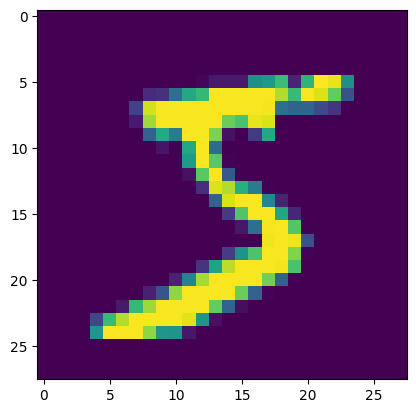

In [15]:
# Check that we have loaded data correctly
print(train_y[0])
plt.imshow(train_x[0]);

In [16]:
# Model
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.stack = nn.Sequential(
                                nn.Linear(28*28,100),
                                nn.ReLU(),
                                nn.Linear(100,10),
                                nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.stack(x)
        return x

model = Net().to('cuda')

model

Net(
  (stack): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
    (3): LogSoftmax(dim=1)
  )
)

In [17]:
# Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [19]:
# Training loop (Uses batch for every iteration)
batchs = 10000
BS = 128

traning_loss = []
for batch in range(0,batchs): 
    # Get random data 
    random_sample = random.sample(range(len(train_y)), BS)
    inputs = torch.tensor(train_x[random_sample]).reshape(-1,28*28).float().to('cuda')
    labels = torch.tensor(train_y[random_sample]).long().to('cuda')

    optimizer.zero_grad() # Reset gradient to zero

    # Forward
    output = model(inputs)

    # Compute loss
    loss = criterion(output, labels)

    # Update loss
    loss.backward()

    # optimizer
    optimizer.step()

    # Current loss
    traning_loss.append(loss.item())


| ID | GPU | MEM |
------------------
|  0 | 14% | 11% |
| ID | GPU | MEM |
------------------
|  0 | 39% | 18% |


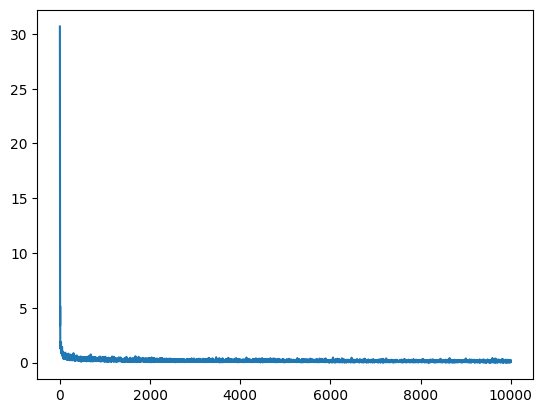

In [20]:
plt.plot(traning_loss);

In [21]:
# Test 

total_correct = 0
with torch.no_grad():
    for idx, test in enumerate(test_x):
        inputs = torch.tensor(test).reshape(-1,28*28).float().to('cuda')
        label = torch.tensor(test_y[idx]).to('cuda')
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total = idx
        total_correct += (predicted == label).sum()

print(f"Accuracy: {(total_correct.item() /  total):.3f}")

Accuracy: 0.951


In [22]:
# Load inn test image from different sources
image = Image.open('test_image.png').convert('L').resize((28, 28))
image_tensor = np.array(image)
image_tensor = torch.tensor(image_tensor).reshape(-1,28*28).float().to('cuda')

In [23]:
# Test model on test image
model.eval()
output = model(image_tensor)
pred = torch.argmax(output, 1)
print(f'Prediction: {pred.item()}')
image

Prediction: 6
